In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import os
import time
import math
import numpy as np
import skimage.io as io
from torchsummary import summary

from di_dataset3 import DepthImageDataset, collate_batch

2022-03-08 15:41:23.831397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/home/patricknit/.mujoco/mjpro150/bin
2022-03-08 15:41:23.831416: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Hyperparams

In [3]:
latent_dim = 64
num_epochs = 250
batch_size = 32
learning_rate = 1e-3

save_model = True
load_model = False

# Load Dataset

In [4]:
tfrecord_folder = "/home/patricknit/rl_data/tfrecord_wfiltered"
tfrecord_test_folder = "/home/patricknit/rl_data/tfrecord_wfiltered/test"

In [5]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size) # 180 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size) # 20 tfrecords

2022-03-08 15:41:25.136741: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-08 15:41:25.136794: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-03-08 15:41:25.137117: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data144.tfrecords']
Iterating length... 	Done: 68
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data190.tfrecords']
Iterating length... 	Done: 65


In [6]:
len_train_dataset = len(train_dataset)
len_test_dataset = len(test_dataset)
n_training_samples = len_train_dataset * 32 # 32 samples per batch
print(len_train_dataset, len_test_dataset)

68 65


In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

In [8]:
dataiter = iter(train_loader)
images, images_filtered, *_ = dataiter.next() # image, filtered image, height, width, depth
images.shape, images_filtered.shape

gotcha


(torch.Size([32, 1, 270, 480]), torch.Size([32, 1, 270, 480]))

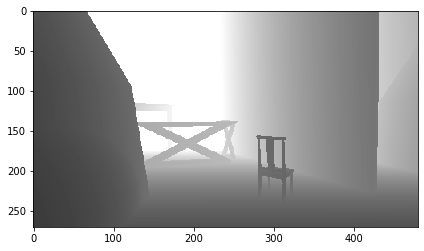

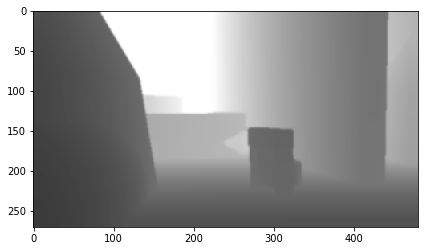

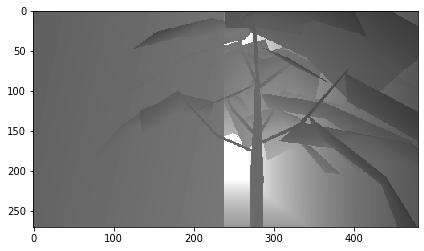

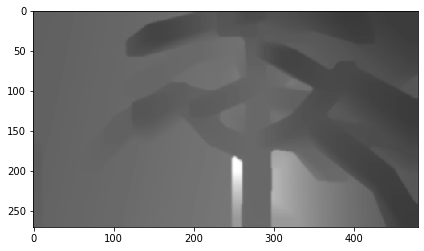

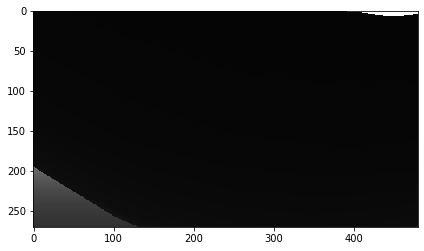

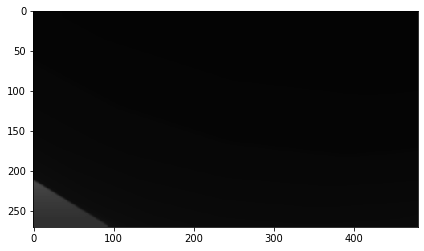

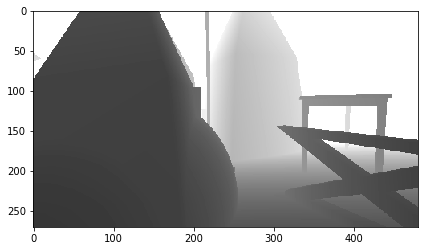

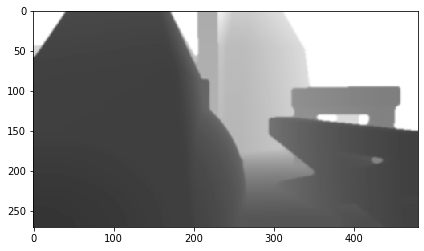

torch.Size([1, 270, 480])

In [9]:
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

num = 4
for image, filtered in zip(images[:num], images_filtered[:num]):
    imshow(image)
    imshow(filtered)
    
image.shape

# Define Variational Autoencoder

Adapted from https://github.com/microsoft/AirSim-Drone-Racing-VAE-Imitation/blob/master/racing_models/cmvae.py

### Dronet
ResNet8 as encoder.

In [10]:
image_batch, *_ = dataiter.next()

In [11]:
class Dronet(nn.Module):
    def __init__(self, input_dim, num_outputs, include_top=True):
        super(Dronet, self).__init__()
        self.include_top = include_top
        
        print('[Dronet] Starting dronet')

        self.max0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # default pool_size='2', strides=2

        self.bn0 = nn.BatchNorm2d(32)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)

        self.conv0 = nn.Conv2d(input_dim, 32, kernel_size=5, stride=2, padding=2)
        self.xavier_uniform_init(self.conv0)
        
        self.conv0_2 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)

        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1) # padding='same' 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv3)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=1, stride=2) # padding='same'
        self.xavier_uniform_init(self.conv6)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv9 = nn.Conv2d(64, 128, kernel_size=1, stride=2) # padding='same'
        self.xavier_uniform_init(self.conv9)

        self.dense0 = nn.Linear(9*15*128, 64) # Todo: check size
        self.dense1 = nn.Linear(64, 32)
        self.dense2 = nn.Linear(32, num_outputs)
        self.dense3 = nn.Linear(9*15*128, num_outputs)

        print('[Dronet] Done with dronet')
    
    
    def xavier_uniform_init(self, m):
        """
        Default initialisation in Keras is glorot_uniform == xavier_uniform in Pytorch

        https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/6?u=ptrblck
        https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('linear')) # gain=nn.init.calculate_gain('relu')
            nn.init.zeros_(m.bias)
        return m

    def forward(self, img):
        # Input
        
        #print(img.shape)
        #print(f"- Before encoding, mean: {img.mean():.3f} var: {img.var():.3f}")
        x1 = self.conv0(img)
        #print("x1:", x1.shape)
        #x1, indices = self.max0(x1)
        x1 = self.conv0_2(x1)
        #print("x1:", x1.shape)

        # First residual block
        x2 = self.bn0(x1)
        #print("x2:", x2.shape)
        # x2 = x1
        x2 = torch.relu(x2)
        #print(x2.shape)
        x2 = self.conv1(x2)
        #print(x2.shape)

        x2 = self.bn1(x2)
        #print(x2.shape)
        x2 = torch.relu(x2)
        #print(x2.shape)
        x2 = self.conv2(x2)
        #print(x2.shape)
        
        
        x1 = self.conv3(x1)
        #print(f"x1: {x1.shape}, x2: {x2.shape}") # 32, 34, 60
        x3 = x1+x2
        #print("x3:", x3.shape)

        # Second residual block
        x4 = self.bn2(x3)
        #print("x4:", x4.shape)
        # x4 = x3
        x4 = torch.relu(x4)
        x4 = self.conv4(x4)
        #print(x4.shape)

        x4 = self.bn3(x4)
        #print(x4.shape)
        x4 = torch.relu(x4)
        x4 = self.conv5(x4)
        #print(x4.shape)
        
        x3 = self.conv6(x3)
        #print(f"x3: {x3.shape}, x4: {x4.shape}")
        x5 = x3+x4 # 34, 60, 64

        # Third residual block
        x6 = self.bn4(x5)
        # x6 = x5
        x6 = torch.relu(x6)
        x6 = self.conv7(x6)

        x6 = self.bn5(x6)
        x6 = torch.relu(x6)
        x6 = self.conv8(x6)

        x5 = self.conv9(x5)
        #print(f"x5: {x5.shape}, x6: {x6.shape}")
        x7 = x5+x6 # 17, 30, 128

        x = x7.view(x7.size(0), -1)
        #print(f"x before linear: {x.shape}")
        #print(f"- After encoding, mean: {x.mean():.3f} var: {x.var():.3f}")

        if self.include_top:
            x = torch.relu(x)
            # x = tf.keras.layers.Dropout(0.5)(x)
            x = self.dense0(x)
            x = self.dense1(x)
            #gate_pose = self.dense2(x)
            x_enc = self.dense2(x)
            # phi_rel = self.dense_phi_rel(x)
            # gate_pose = tf.concat([gate_pose, phi_rel], 1)
            #print(f"x_enc: {x.shape}")
            return x_enc
        else:
            x = self.dense3(x)
            #print(f"x_enc: {x.shape}")
            return x

dronet = Dronet(input_dim=1, num_outputs=latent_dim*2, include_top=True)
summary(dronet, input_size=(1, 270, 480), batch_size=-1, device=device.type)

[Dronet] Starting dronet
[Dronet] Done with dronet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 30]           2,112
      BatchNorm2d-13           [-1, 64, 17, 30]     

### Decoder

In [12]:
class ImgDecoder(nn.Module):
    def __init__(self, input_dim=100, batch=32):
        super(ImgDecoder, self).__init__()
        print('[ImgDecoder] Starting create_model')
        self.dense = nn.Linear(input_dim, 9*15*128)
        
        self.bn0 = nn.BatchNorm2d(128)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv6 = nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0))
        self.deconv7 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1, padding=2) # tanh activation or sigmoid

        print('[ImgDecoder] Done with create_model')

    def forward(self, z):
        #print("z: ", z.shape)
        x = self.dense(z)
        #print(x.shape)
        x = x.view(x.size(0), 128, 9, 15)
        #print(f"- Before deconv, mean: {x.mean():.3f} var: {x.var():.3f}")
        
        x = self.deconv1(x)
        x = torch.relu(x)
        #print("after deconv1", x.shape)
        
        x = self.deconv2(x)
        x = torch.relu(x)
        #print("after deconv2", x.shape)
        
        x = self.deconv3(x)
        x = torch.relu(x)
#         print("after deconv3", x.shape)

        x = self.deconv4(x)
        x = torch.relu(x)
#         print("after deconv4", x.shape)

        x = self.deconv5(x)
        #print("indices", indices.shape)
        #x = self.unpool(x, indices, output_size=(x.size(0), 1, 135, 240))
#       print("after deconv5", x.shape)
        x = torch.relu(x)
        #print("after unpool", x.shape)
        
        x = self.deconv6(x)
        x = torch.relu(x)
#         print("after deconv6", x.shape)

        x = self.deconv7(x)
        #print(f"- After deconv 7, mean: {x.mean():.3f} var: {x.var():.3f}")
        x = torch.sigmoid(x)
        #print(f"- After sigmoid, mean: {x.mean():.3f} var: {x.var():.3f}")
        #print("after deconv7", x.shape)
        return x

img_decoder = ImgDecoder(input_dim=latent_dim, batch=1)
summary(img_decoder, (1,latent_dim))

[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 17280]       1,123,200
   ConvTranspose2d-2           [-1, 128, 9, 15]         147,584
   ConvTranspose2d-3           [-1, 64, 17, 30]         204,864
   ConvTranspose2d-4           [-1, 64, 34, 60]         147,520
   ConvTranspose2d-5          [-1, 32, 68, 120]          73,760
   ConvTranspose2d-6         [-1, 32, 135, 240]          25,632
   ConvTranspose2d-7         [-1, 16, 270, 480]          18,448
   ConvTranspose2d-8          [-1, 1, 270, 480]             401
Total params: 1,741,409
Trainable params: 1,741,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 28.22
Params size (MB): 6.64
Estimated Total Size (MB): 34.86
------------------------------

## VAE

In [13]:
class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
        

class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        
        # create the 3 base models:
        self.q_img = Dronet(input_dim=1, num_outputs=n_z*2, include_top=True)
        self.p_img = ImgDecoder(input_dim=n_z)
        
        # Create sampler
        self.mean_params = Lambda(lambda x: x[:, :n_z])
        self.logvar_params = Lambda(lambda x: x[:, n_z:])

    def forward(self, x):
        # Possible modes for reconstruction:
        # img -> img

        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        #print(z.shape)
        #print("OK")
        img_recon = self.p_img(z)
        
        return img_recon, means, logvar, z
    
    def forward_test(self, x):
        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.zeros_like(stddev)
        z = means + eps * stddev
        #print(z.shape)
        #print("OK")
        img_recon = self.p_img(z)
        return img_recon, means, logvar, z
        

    def encode(self, x):
        x = self.q_img(x)
        means = self.mean_params(x)
        stddev = torch.exp(0.5 * self.stddev_params(x))
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        return z, means, stddev

    def decode(self, z, mode):
        # Possible modes for reconstruction:
        # z -> img
        img_recon = self.p_img(z)
        return img_recon


### Define Model

In [14]:
vae_model = VAE(n_z=latent_dim)

load_model_file = "/home/patricknit/vae_models/vae_dronet_sigmoid_MSE_weighted_90.pth"
load_model = True

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
else:
    vae_model.train()

optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
summary(vae_model, (1, 270, 480))

[Dronet] Starting dronet
[Dronet] Done with dronet
[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 3

# Training

In [15]:
def depth_gain(x):
    return 1/(x + 0.5) - 0.5

def BCELoss(x, x_hat, mean, log_var):
    reproduction_loss = nn.BCELoss(reduction='sum')(x_hat, x)
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

def MSE(x, x_hat, mu, logvar):
    #rep = (x_hat - x)**2
    reproduction_loss = F.mse_loss(x_hat, x, reduction="sum")
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence

def weighted_MSE(x, x_hat, mu, logvar):
    reproduction_loss_ref = F.mse_loss(x_hat, x, reduction="sum")
    
    reproduction_loss = (depth_gain(x) * torch.square(x_hat - x)).sum()
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    #print(reproduction_loss, reproduction_loss_ref)
    return reproduction_loss - kl_divergence

In [ ]:
time_iteration = []
# train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
# train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
# train_loader = next(iter(train_loader))

save_model_file = "/home/patricknit/vae_models/vae_dronet_sigmoid_MSE_weighted"

for epoch in range(90, num_epochs):
    overall_loss = 0
    overall_elbo = 0
    since = time.time()
    
    # Random file each time
    train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    n_iterations = len(train_loader)
    
    for i, (image, *_) in enumerate(train_loader):
        since_iter = time.time()

        optimiser.zero_grad()

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = weighted_MSE(image, x_hat, mu, logvar)
        #print(loss)

        overall_loss += loss

        # Update weights
        
        loss.backward()
        optimiser.step()
        
        
        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
        
        if (i+1) % (5) == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}, Est. time left {iter_time_mean*(n_iterations - (i+1)):.2f}")
            print()
            
        if (i+1) % (15) == 0:
            imshow(image[0])
            imshow(x_hat[0].detach())
            
    if (epoch+1) % 10 == 0:
        save_model_file_dir = save_model_file + f"_{epoch+1}.pth"
        torch.save(vae_model.state_dict(), save_model_file_dir)
            

Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data135.tfrecords']
Iterating length... 	Done: 64
gotcha
Epoch: 91/250, Step: 5/64, Avg loss: 887.636, time: 28.04, Avg. per iter 5.26, Est. time left 310.19



# Some results

### BCE
- 10 epochs, no batch norm: 60191.195

### BCE with unpooling
- 10 epochs, clear reconstruction but image indices carried through VAE. Faster training than BCE

### ReLU + MSE loss
- Avg loss: 2629.289, very poor reconstruction

In [ ]:
# torch.save(vae_model.state_dict(), save_model_file)

In [ ]:
#load_model_file = "/home/patricknit/vae_models/vae_dronet_sigmoid_MSE_weighted_57.pth"
load_model=False

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    vae_model.eval()
else:
    vae_model.train()

# Evaluation

In [ ]:
vae_model.eval()

# Visualise sample of images
with torch.no_grad():
    
    images, *_ = next(iter(test_loader))

    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), x_hat.mean())
    print(images.var(), x_hat.var())
    print(images.shape)
    for idx in range(len(images)):
        # show images
        imshow(images[idx])
        imshow(x_hat[idx])

In [ ]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)

vae_model.eval()
# Visualise sample of images

with torch.no_grad():
        
    images, *_ = next(iter(train_loader)) # if dataset is shuffled every iter(), essentially test 
    # VAE forward pass
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), x_hat.mean())
    print(images.var(), x_hat.var())
    print(images.shape)
    for idx in range(len(images)):
        # show images
        imshow(images[idx])
        imshow(x_hat[idx])
